# **Data generation**

In [1]:
import numpy as np
from scipy.stats import norm
from datetime import datetime
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
def black_model(F, K, T, sigma, option_type='call'):
	# Parameters
	d1 = (np.log(F / K) + (sigma**2 / 2) * T) / (sigma * np.sqrt(T))
	d2 = d1 - sigma * np.sqrt(T)

	# Discount factor (assuming risk-free rate is 0)
	DF_T = 1

	if option_type == 'call':
		return DF_T * (F * norm.cdf(d1) - K * norm.cdf(d2))
	elif option_type == 'put':
		return DF_T * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
	else:
		raise ValueError("option_type must be 'call' or 'put'")

def generate_data(num_samples, S=1):
	# Generate random parameters
	K = np.random.uniform(0.4, 2.5, num_samples)
	T = np.random.uniform(0.004, 4, num_samples)
	sigma = np.random.uniform(0.1, 0.5, num_samples)

	# Determine option types (1 for call, 0 for put)
	option_types = np.where(K >= S, 1, 0)

	# Generate prices based on option type
	prices = np.array([black_model(S, k, t, s, 'call' if ot == 1 else 'put') 
					   for k, t, s, ot in zip(K, T, sigma, option_types)])

	# Preparing input features and target vectors
	# Add the option_type (1 for call, 0 for put) as an additional feature
	X = np.vstack((K, T, sigma*np.sqrt(T), np.log(K))).T
	y = prices

	return X, y

In [3]:
def generate_static_test_data(num_test_samples=100000, file_name='static_test_data.pt'):

	# Generate test data
	X_test, y_test = generate_data(num_samples=num_test_samples)

	# Convert to tensors
	X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
	y_test_tensor = torch.tensor(y_test, dtype=torch.float64).unsqueeze(1)

	# Save the test data
	torch.save((X_test_tensor, y_test_tensor), file_name)

def load_static_test_data(file_name='static_test_data.pt'):
	# Load test data from the file
	X_test_tensor, y_test_tensor = torch.load(file_name)
	return X_test_tensor, y_test_tensor

In [4]:
def generate_and_prepare_training_data(num_train_samples=1000000, batch_size=128):
	# Generate training data
	X_train, y_train = generate_data(num_samples=num_train_samples)

	# Convert to tensors
	X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
	y_train_tensor = torch.tensor(y_train, dtype=torch.float64).unsqueeze(1)

	# Create DataLoader
	train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

	return train_loader

# **Train**

## Model definition

In [5]:
import torch.nn as nn
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import math

In [6]:
class SineActivation(nn.Module):
	def __init__(self, omega_0=30):
		super().__init__()
		self.omega_0 = omega_0

	def forward(self, x):
		return torch.sin(self.omega_0 * x)

class SIRENLayer(nn.Module):
	def __init__(self, input_size, output_size, omega_0=30):
		super().__init__()
		self.omega_0 = omega_0
		self.linear = nn.Linear(input_size, output_size, dtype=torch.float64)
		self.init_weights()

	def init_weights(self):
		with torch.no_grad():
			self.linear.weight.uniform_(-math.sqrt(6 / self.linear.in_features) / self.omega_0,
										 math.sqrt(6 / self.linear.in_features) / self.omega_0)

	def forward(self, x):
		return torch.sin(self.omega_0 * self.linear(x))

class SIREN(nn.Module):
	def __init__(self, input_size, hidden_size, hidden_layers, output_size, omega_0=30):
		super().__init__()
		self.omega_0 = omega_0

		# Input layer
		self.net = [SIRENLayer(input_size, hidden_size, omega_0=omega_0)]

		# Hidden layers
		for _ in range(hidden_layers):
			self.net.append(SIRENLayer(hidden_size, hidden_size, omega_0=omega_0))

		# Output layer
		self.net.append(nn.Linear(hidden_size, output_size, dtype=torch.float64))

		# Wrap the layers in nn.Sequential
		self.net = nn.Sequential(*self.net)
		
		self.name = "SIREN model"

	def forward(self, x):
		return self.net(x)


In [7]:
class KAN(nn.Module):
	def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1):
		super(KAN, self).__init__()
		self.input_projection = nn.Linear(input_size, hidden_size, dtype=torch.float64)  # Project input to hidden size
		self.kernel_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4, batch_first=True, dtype=torch.float64)
		self.fc1 = nn.Sequential(
			nn.Linear(hidden_size, hidden_size, dtype=torch.float64),
			nn.Tanh(),
			nn.Dropout(dropout_p)
		)
		self.fc2 = nn.Linear(hidden_size, output_size, dtype=torch.float64)
		self.name = 'KAN model'

	def forward(self, x):
		x = self.input_projection(x)  # Project input to hidden size
		x = x.unsqueeze(1)  # Add fake sequence dimension
		attn_output, _ = self.kernel_attention(x, x, x)
		x = attn_output.squeeze(1)  # Remove sequence dimension
		x = self.fc1(x)
		output = self.fc2(x)
		
		return output

In [8]:
class MLP(nn.Module):
	def __init__(self, input_size=1, hidden_size=128, output_size=1, dropout_p = 0.33):
		super(MLP, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size, dtype=torch.float64)
		self.bn1 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)  # Batch Normalization
		self.fc2 = nn.Linear(hidden_size, hidden_size, dtype=torch.float64)
		self.bn2 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)  # Batch Normalization
		self.fc3 = nn.Linear(hidden_size, output_size, dtype=torch.float64)
		self.dropout = nn.Dropout(p=dropout_p)  # Dropout for regularization
		self.name = 'MLP relu'

	def forward(self, x):
		x = F.relu(self.bn1(self.fc1(x)))  # ReLU and Batch Normalization
		x = self.dropout(x)  # Dropout
		x = F.relu(self.bn2(self.fc2(x)))  # ReLU and Batch Normalization
		x = self.fc3(x)
		
		return x

In [9]:
class MLPA(nn.Module):
	def __init__(self, input_size=1, hidden_size=128, output_size=1, dropout_p = 0.33):
		super(MLPA, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size, dtype=torch.float64)
		self.bn1 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)  # Batch Normalization
		self.fc2 = nn.Linear(hidden_size, hidden_size, dtype=torch.float64)
		self.bn2 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)  # Batch Normalization
		self.fc3 = nn.Linear(hidden_size, output_size, dtype=torch.float64)
		self.dropout = nn.Dropout(p=dropout_p)  # Dropout for regularization
		self.name = 'MLP tanh'

	def forward(self, x):
		x = F.tanh(self.bn1(self.fc1(x)))  # Tanh and Batch Normalization
		x = self.dropout(x)  # Dropout
		x = F.tanh(self.bn2(self.fc2(x)))  # Tanh and Batch Normalization
		x = self.fc3(x)
		
		return x

In [10]:
class ResNet(nn.Module):
	def __init__(self, input_size=1, hidden_size=128, output_size=1, dropout_p=0.3):
		super(ResNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size, dtype=torch.float64)
		self.bn1 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)
		self.fc2 = nn.Linear(hidden_size, hidden_size, dtype=torch.float64)
		self.bn2 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)
		self.fc_out = nn.Linear(hidden_size, output_size, dtype=torch.float64)
		self.dropout = nn.Dropout(p=dropout_p)
		self.name = 'ResNet Model'

	def forward(self, x):
		residual = self.fc1(x)  # Transform residual to match shape of x
		x = F.tanh(self.bn1(self.fc1(x)))
		x = self.dropout(x)
		x = F.tanh(self.bn2(self.fc2(x)))
		x = x + residual  # Adding the skip connection after matching dimensions
		x = self.fc_out(x)
		
		return x

In [11]:
class BlackScholesNet(nn.Module):
	def __init__(self, input_size=1, hidden_size=128, output_size=2, dropout_p = 0.33):
		super(BlackScholesNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size, dtype=torch.float64)
		self.bn1 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)  # Batch Normalization
		self.fc2 = nn.Linear(hidden_size, hidden_size, dtype=torch.float64)
		self.bn2 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)  # Batch Normalization
		self.fc3 = nn.Linear(hidden_size, output_size, dtype=torch.float64)
		self.dropout = nn.Dropout(p=dropout_p)  # Dropout for regularization
		self.name = 'Black Model'

	def forward(self, x, K):
		x = F.tanh(self.bn1(self.fc1(x)))  # Tanh and Batch Normalization
		x = self.dropout(x)  # Dropout
		x = F.tanh(self.bn2(self.fc2(x)))  # Tanh and Batch Normalization
		x = self.fc3(x)
		x1, x2 = x[:, [0]], x[:, [1]]
		
		return F.sigmoid(x1) - K * F.sigmoid(x2)

## Prepare the training data

In [12]:
num_train_samples = {
	"n" : 1000,
	"s" : 10000,
	"m" : 100000,
	"l" : 1000000,
	# "x" : 10000000 # Requires a long time to generate and train, so this size is optional
}
batch_size = 128

In [13]:
def create_train_loader(num_train_samples, batch_size):
	return {
		key: generate_and_prepare_training_data(num_samples, batch_size)
		for key, num_samples in num_train_samples.items()
	}

In [14]:
train_loader = create_train_loader(num_train_samples, batch_size)
n_features = train_loader["n"].dataset.tensors[0].shape[1]

## Model initialization

In [15]:
def weights_init(m):
	if isinstance(m, nn.Linear):
		nn.init.xavier_uniform_(m.weight)
		if m.bias is not None:
			nn.init.constant_(m.bias, 0)

In [16]:
def init_models(input_size, hidden_size, output_size, dropout_p, lr, patience, device):
	models = []
	optimizers = []
	schedulers = []

	models.append( MLP(input_size=input_size, output_size=output_size, hidden_size=hidden_size, dropout_p=dropout_p) )
	models.append( MLPA(input_size=input_size, output_size=output_size, hidden_size=hidden_size, dropout_p=dropout_p) )
	
	models.append( ResNet(input_size=n_features, output_size=output_size, hidden_size=hidden_size, dropout_p=dropout_p) )

	models.append( KAN(input_size=n_features, output_size=output_size, hidden_size=hidden_size, dropout_p=dropout_p) )

	models.append( SIREN(input_size=n_features, output_size=output_size, hidden_size=hidden_size, hidden_layers=4) )

	for model in models:
		optimizer = optim.NAdam(model.parameters(), lr=lr)
		scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience)
		optimizers.append(optimizer)
		schedulers.append(scheduler)

		model.to(device)

		model.apply(weights_init)

	return models, optimizers, schedulers


## Training loop

In [17]:
def train(num_epochs, train_loader, models, optimizers, schedulers, size_label, device, loss_function, train_metrics):
	for epoch in range(num_epochs):
		# Initialize epoch metrics for each model
		epoch_mae = [0.] * len(models)
		epoch_mre = [0.] * len(models)
		epoch_mse = [0.] * len(models)

		for X_batch, y_batch in train_loader[size_label]:
			X_batch, y_batch = X_batch.to(device), y_batch.to(device)

			# Loop over each model
			for i, model in enumerate(models):
				model.train()

				# Forward pass
				outputs = model(X_batch)
				outputs = outputs[:, 0]
				y = y_batch[:, 0]

				# Calculate losses
				mask = y >= 1e-10
				y_m = y[mask]
				relative_errors = torch.abs(outputs[mask] - y_m ) / y_m

				losses = {
					"mse" : F.mse_loss(outputs, y),
					"mae" : F.l1_loss(outputs, y),
					"mre" : relative_errors.mean()
				}

				# Backpropagation
				optimizers[i].zero_grad()
				losses[loss_function].backward()
				optimizers[i].step()

				# Accumulate losses for this model
				epoch_mse[i] += losses["mse"].item()
				epoch_mae[i] += losses["mae"].item()
				epoch_mre[i] += losses["mre"].item()

		print(f"[ {datetime.now().strftime("%H:%M:%S")} ] ----- Epoch [{epoch+1}/{num_epochs}] {'-'*150}")
		# Average metrics for each model
		for i in range(len(models)):
			epoch_losses = {
				"mse" : epoch_mse[i] / len(train_loader[size_label]),
				"mae" : epoch_mae[i] / len(train_loader[size_label]),
				"mre" : epoch_mre[i] / len(train_loader[size_label])
			}

			print(f"{models[i].name:<50} | MSE: {epoch_losses["mse"]:<25} | MAE: {epoch_losses["mae"]:<25} | MRE: {epoch_losses["mre"]:<25} |")

			# Scheduler step
			schedulers[i].step(epoch_losses[loss_function])

			if (epoch+1) % 10 == 0 or epoch+1==1:
				train_metrics[models[i].name][size_label][epoch+1] = {key : value for key, value in epoch_losses.items()}

## Saving models

In [18]:
from pathlib import Path

def save_models(models, train_sizes):
	for size in train_sizes:
		for model in models[size]:
			dir_path = Path(f"models/{size}")
			dir_path.mkdir(parents=True, exist_ok=True)
			
			if dir_path.exists():
				model_path = dir_path / f"{model.name}.pth"
				torch.save(model, model_path)

# **Evaluation**

### Generate test data

In [19]:
num_test_samples = {key: int(value * 0.2) for key, value in num_train_samples.items()}
batch_size = 128

In [20]:
import os 

def generate_test_data(sizes):
	for size in sizes.keys():
		os.makedirs("data", exist_ok=True)
		generate_static_test_data(sizes[size], f"data/static_test_data_{size}.pt")

In [21]:
generate_test_data(num_test_samples)

In [22]:
test_loader = {}

for size in num_test_samples.keys():
	X_test_tensor, y_test_tensor = load_static_test_data(f"data/static_test_data_{size}.pt")

	test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
	test_loader[size] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\serpo\AppData\Local\Temp\ipykernel_1356\3539053712.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test_tensor, y_test_tensor = torch.load(file_name)


### Implied volatility

In [23]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException, AboveMaximumException

In [24]:
def torch_implied_volatility(prices, S, K, T, r, option_type, device):
	"""
	Calculate implied volatility for a batch of options using PyTorch.
	"""
	ivs = []
	for price, k, t, option in zip(prices, K, T, option_type):
		# Validate inputs
		if price <= 0 or not torch.isfinite(price):
			ivs.append(float('nan'))
			continue
		if S <= 0 or k <= 0 or t <= 0:
			ivs.append(float('nan'))
			continue

		try:
			option_str = 'c' if option.item() == 1 else 'p'
			
			# Calculate implied volatility
			iv = implied_volatility(price.item(), S, k.item(), t.item(), r, option_str)
			ivs.append(iv)
		except (BelowIntrinsicException, AboveMaximumException, OverflowError):
			ivs.append(float('nan'))  # Handle exceptions by appending NaN

	# Convert the list of implied volatilities to a PyTorch tensor
	return torch.tensor(ivs, dtype=torch.float64, device=device)

### Validation

In [25]:
def has_nan(tensor):
	return torch.isnan(tensor).any()

def validate(models, test_loader, size_label, test_size_label, device, test_metrics):
	# Initialize metrics for each model
	test_mses = {model.name: 0. for model in models}
	test_maes = {model.name: 0. for model in models}
	test_max_aes = {model.name: 0. for model in models}
	test_mres = {model.name: 0. for model in models}
	test_max_res = {model.name: 0. for model in models}
	test_iv_mses = {model.name: 0. for model in models}
	mre_cnt = 0

	# Set models to evaluation mode and iterate over each model
	for model in models:
		model.eval()  # Set the current model to evaluation mode

		# Initialize model-specific metrics
		test_mse = 0.
		test_mae = 0.
		test_max_ae = 0.
		test_mre = 0.
		test_max_re = 0.
		test_iv_mse = 0.
		notnan = 0
		mre_cnt = 0
		
		with torch.inference_mode():
			for X_batch, y_batch in test_loader[test_size_label]:
				X_batch, y_batch = X_batch.to(device), y_batch.to(device)

				# Forward pass
				outputs = model(X_batch)
				outputs = outputs[:, 0]

				y = y_batch[:, 0]

				# Mean Squared Error (MSE)
				mse_loss = F.mse_loss(outputs, y)
				test_mse += mse_loss.item()

				# Mean Absolute Error (MAE)
				abs_errors = torch.abs(outputs - y)
				test_mae += abs_errors.sum().item()

				# Maximum Absolute Error (Max AE)
				max_ae = abs_errors.max().item()
				test_max_ae = max(test_max_ae, max_ae)

				# Mean Relative Error (MRE)
				mask = y >= 1e-10
				y_m = y[mask]
				relative_errors = torch.abs(outputs[mask] - y_m) / y_m

				# Calculate MRE
				test_mre += relative_errors.sum().item()
				mre_cnt += len(relative_errors)

				# Calculate max relative error
				test_max_re = max(test_max_re, relative_errors.max().item())

				# Calculate implied volatility
				S = 1.
				K = X_batch[:, 0]
				T = X_batch[:, 1]

				# Determine option types as a tensor
				option_types = torch.where(K >= S, 1, 0)  # 'c' for call, 'p' for put

				ivs1 = torch_implied_volatility(outputs, S, K, T, 0, option_types, device)
				ivs2 = torch_implied_volatility(y_batch, S, K, T, 0, option_types, device)

				if has_nan(ivs1) or has_nan(ivs2):
					mask = torch.isnan(ivs1)
					K_nan = K[mask]
					T_nan = T[mask]

					mask = ~torch.isnan(ivs1) & ~torch.isnan(ivs2)
					ivs1 = ivs1[mask]
					ivs2 = ivs2[mask]

				notnan += ivs1.shape[0]
				if ivs1.shape[0] == 0 or ivs2.shape[0] == 0:
					continue

				iloss = F.mse_loss(ivs1, ivs2)
				if has_nan(iloss):
					print("NaN in loss calculation")
					
				test_iv_mse += iloss.item()

		# Calculate the average metrics over all test samples for each model
		avg_test_mse = test_mse / len(test_loader[test_size_label].dataset)
		avg_test_mae = test_mae / len(test_loader[test_size_label].dataset)
		avg_test_mre = test_mre / mre_cnt if mre_cnt !=0 else 0.
		avg_test_iv_mse = test_iv_mse / notnan if notnan !=0 else 0.

		# Store results for this model
		test_mses[model.name] = avg_test_mse
		test_maes[model.name] = avg_test_mae
		test_max_aes[model.name] = test_max_ae
		test_mres[model.name] = avg_test_mre
		test_max_res[model.name] = test_max_re
		test_iv_mses[model.name] = avg_test_iv_mse
		

		# Print the results for each model
		print('-'*250)
		print(f"{model.name:<20} with dataset size -- {test_size_label} Results | MSE: {avg_test_mse:<25} | MAE: {avg_test_mae:<25} | Max AE: {test_max_ae:<25} | MRE: {avg_test_mre:<25} | Max RE: {test_max_re:<25} | IV MSE: {avg_test_iv_mse:<25}")

		sz = f"test_size_{test_size_label}"
		test_metrics[sz][model.name][size_label]["mse"] = avg_test_mse
		test_metrics[sz][model.name][size_label]["mae"] = avg_test_mae
		test_metrics[sz][model.name][size_label]["max_ae"] = test_max_ae
		test_metrics[sz][model.name][size_label]["mre"] = avg_test_mre
		test_metrics[sz][model.name][size_label]["max_re"] = test_max_re
		test_metrics[sz][model.name][size_label]["iv_mse"] = avg_test_iv_mse


# **Tests**

In [26]:
hidden_size = 128
output_size = 1
patience = 3
num_epochs = 100
dropout_p = 0.10830718268190546
lr = 0.09638266753852863
device = torch.device('cpu')
loss_function = "mae"

In [27]:
train_metrics = {}
test_metrics = {}

In [28]:
models = {}
optimizers = {}
schedulers = {}

In [29]:
train_sizes = train_loader.keys()
test_sizes = test_loader.keys()

In [30]:
for size in train_sizes:
	models[size], optimizers[size], schedulers[size] = init_models(input_size=n_features, hidden_size=hidden_size, output_size=output_size, dropout_p=dropout_p, lr=lr, patience=patience, device=device)
	model_names = [model.name for model in models[size]]

	if not train_metrics and not test_metrics:
		# Initialize test metrics
		for _key_test in test_sizes:
			sz = f"test_size_{_key_test}"
			test_metrics[sz] = {model_name: {key: {} for key in train_sizes} for model_name in model_names}

		# Initialize train metrics
		for _model in models[size]:
			model_name = _model.name
			train_metrics[model_name] = {key: {epoch: {} for epoch in range(1, num_epochs + 1) if epoch % 10 == 0 or epoch == 1} 
										for key in train_sizes}

	print(f"DATASET SIZE IS {size}\n")

	print(f"[ {datetime.now().strftime("%H:%M:%S")} ] ----- TRAIN {"-"*250}\n")
	train(num_epochs=num_epochs, train_loader=train_loader, models=models[size], optimizers=optimizers[size], schedulers=schedulers[size], size_label=size, device=device, loss_function=loss_function, train_metrics=train_metrics)

	print(f"\n[ {datetime.now().strftime("%H:%M:%S")} ] ----- VALIDATION {"-"*250}\n")
	for size_test in test_sizes:
		print(f"Test size: {size_test}")
		validate(models=models[size], test_loader=test_loader, size_label=size, test_size_label=size_test, device=device, test_metrics=test_metrics)
		print("\n")

	print("\n"*5)

DATASET SIZE IS n

[ 06:46:44 ] ----- TRAIN ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[ 06:46:44 ] ----- Epoch [1/100] ------------------------------------------------------------------------------------------------------------------------------------------------------
MLP relu                                           | MSE: 8.490802582173687         | MAE: 1.8716339442217786        | MRE: 61725045.15128116         |
MLP tanh                                           | MSE: 15.553325662787422        | MAE: 2.6738048062059443        | MRE: 85082559.79784738         |
ResNet Model                                       | MSE: 26.166430308315142        | MAE: 3.6224353841318884        | MRE: 81029452.27150553         |
KAN model                                          | MSE: 46.388

In [31]:
train_metrics

{'MLP relu': {'n': {1: {'mse': 8.490802582173687,
    'mae': 1.8716339442217786,
    'mre': 61725045.15128116},
   10: {'mse': 0.0031991957603319035,
    'mae': 0.046041007503620016,
    'mre': 864309.5767554935},
   20: {'mse': 0.002228222998254057,
    'mae': 0.03459746135738952,
    'mre': 525794.9690572269},
   30: {'mse': 0.000539561007459757,
    'mae': 0.01584914963135618,
    'mre': 171621.15910895032},
   40: {'mse': 0.0003082372423892538,
    'mae': 0.01175058444809655,
    'mre': 70839.40740540499},
   50: {'mse': 0.000383402625794089,
    'mae': 0.013007304228757954,
    'mre': 57457.50849671729},
   60: {'mse': 0.0003180345408967099,
    'mae': 0.012010512992549753,
    'mre': 48830.84095092521},
   70: {'mse': 0.00040586767634686054,
    'mae': 0.013345813792990557,
    'mre': 42155.36155728179},
   80: {'mse': 0.0002733802048378661,
    'mae': 0.011038167767997499,
    'mre': 76109.38748026229},
   90: {'mse': 0.00020711444377240597,
    'mae': 0.009912461003712883,
    

In [32]:
test_metrics

{'test_size_n': {'MLP relu': {'n': {'mse': 1.2378448949559485e-06,
    'mae': 0.007038383222724642,
    'max_ae': 0.05980289696652166,
    'mre': 1444.8687512889,
    'max_re': 173275.7191986512,
    'iv_mse': 1.9812741266556606e-05},
   's': {'mse': 7.981322012966924e-07,
    'mae': 0.005638976669718494,
    'max_ae': 0.028745068291591486,
    'mre': 334.51904321295757,
    'max_re': 42596.121580528736,
    'iv_mse': 0.00011895376615058968},
   'm': {'mse': 2.6727038511208713e-07,
    'mae': 0.0025589581341262492,
    'max_ae': 0.028340763279973008,
    'mre': 101.7055536855238,
    'max_re': 8280.577942095724,
    'iv_mse': 0.00019267481026484184},
   'l': {'mse': 1.470198795746267e-07,
    'mae': 0.0020071274999191465,
    'max_ae': 0.022085247105369604,
    'mre': 96.94391407967122,
    'max_re': 7892.6615029053355,
    'iv_mse': 0.0001888952931809557}},
  'MLP tanh': {'n': {'mse': 3.042093195233252e-06,
    'mae': 0.010862673352046057,
    'max_ae': 0.10277483166637486,
    'mre':

## Saving results

In [33]:
import json

def save_train_results_to_json(train_metrics, file_path):
	with open(file_path, "w") as file:
		json.dump(train_metrics, file, indent=4)

def save_test_results_to_json(test_metrics, file_path):
	with open(file_path, "w") as file:
		json.dump(test_metrics, file, indent=4)

def save_train_results_to_text(train_metrics, file_path):
	with open(file_path, "w") as file:
		for model_name, size_results in train_metrics.items():
			file.write(f"Model: {model_name}\n")
			for size_label, epoch_results in size_results.items():
				file.write(f"  Dataset Size: {size_label}\n")
				for epoch, metrics in epoch_results.items():
					file.write(f"	Epoch {epoch}:\n")
					for metric, value in metrics.items():
						file.write(f"	  {metric}: {value}\n")
			file.write(f"\n{"-"*50}\n\n")
			file.write("\n")
			
def save_test_results_to_text(test_metrics, file_path):
	with open(file_path, "w") as file:
		for test_size, model_results in test_metrics.items():
			file.write(f"Test size: {test_size}\n")
			for model_name, size_results in model_results.items():
				file.write(f"  Model: {model_name}\n")
				for size_label, metrics in size_results.items():
					if metrics:  # Only write if there are metrics available
						file.write(f"	Train Dataset Size: {size_label}\n")
						for metric, value in metrics.items():
							file.write(f"	  {metric}: {value}\n")
				file.write("\n")
			file.write(f"{"-"*50}\n\n")

In [34]:
os.makedirs("results", exist_ok=True)

save_train_results_to_json(train_metrics, "results/train_results.json")
save_test_results_to_json(test_metrics, "results/test_results.json")

save_train_results_to_text(train_metrics, "results/train_results.txt")
save_test_results_to_text(test_metrics, "results/test_results.txt")

In [35]:
save_models(models, train_sizes)

# **Downloading pretrained models (optional)**

In [71]:
import gdown
import zipfile
import os

file_id = '1R7brQVkYv4gktdrMgq7ibr9_aERHA2NW'

url = f'https://drive.google.com/uc?id={file_id}'

# Download the file
output = 'models_trained.zip'  # Path to save the downloaded zip file
gdown.download(url, output, quiet=False)

# Unzip the file
unzip_dir = './'  # Directory to extract the contents


with zipfile.ZipFile(output, 'r') as zip_ref:
	zip_ref.extractall(unzip_dir)

print(f'Models have been extracted to {unzip_dir}')

Downloading...
From: https://drive.google.com/uc?id=1R7brQVkYv4gktdrMgq7ibr9_aERHA2NW
To: c:\Users\serpo\Documents\Python\BlackFormulaApproximation\models_trained.zip
100%|██████████| 6.36M/6.36M [00:00<00:00, 14.3MB/s]

Models have been extracted to ./


In [72]:
test_metrics_trained = {}

In [73]:
models_trained = {}

In [ ]:
from pathlib import Path

for size in os.listdir(f"{unzip_dir}/models_trained"):
	models_list = []
	
	for model_file in os.listdir(f"{unzip_dir}/models_trained/{size}"):
		models_list.append(torch.load(f"{unzip_dir}/models_trained/{size}/{model_file}"))
	
	models_trained[size] = models_list

C:\Users\serpo\AppData\Local\Temp\ipykernel_1356\2080992284.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models_list.append(torch.load(f"{unzip_dir}/models_trained/{s

In [75]:
models_trained

{'l': [KAN(
    (input_projection): Linear(in_features=4, out_features=128, bias=True)
    (kernel_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (fc1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.10830718268190546, inplace=False)
    )
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  ),
  MLP(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.10830718268190546, inplace=False)
  ),
  MLPA(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (bn1): BatchN

In [76]:
test_sizes = test_loader.keys()

In [77]:
for size in test_sizes:
	models_trained[size]
	model_names = [model.name for model in models_trained[size]]

	if not test_metrics_trained:
		# Initialize test metrics
		for _key_test in train_sizes:
			sz = f"test_size_{_key_test}"
			test_metrics_trained[sz] = {model_name: {key: {} for key in train_sizes} for model_name in model_names}

	print(f"DATASET SIZE IS {size}\n")

	print(f"\n[ {datetime.now().strftime("%H:%M:%S")} ] ----- VALIDATION {"-"*250}\n")
	for size_test in train_sizes:
		print(f"Test size: {size_test}")
		validate(models=models_trained[size], test_loader=test_loader, size_label=size, test_size_label=size_test, device=device, test_metrics=test_metrics_trained)
		print("\n")

	print("\n"*5)

DATASET SIZE IS n


[ 15:12:48 ] ----- VALIDATION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Test size: n
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
KAN model            with dataset size -- n Results | MSE: 3.8648635695426156e-05    | MAE: 0.050903132004988944      | Max AE: 0.2707137655863806        | MRE: 65112.976917132175        | Max RE: 5306188.837246982         | IV MSE: 0.0036185923606628645    
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Greeks**

In [49]:
import torch
from torch.distributions import Normal

def d1(K, T, sigma, F):
	return (torch.log(F / K) + (0.5 * sigma**2) * T) / (sigma * torch.sqrt(T))

def d2(d1, T, sigma):
	return d1 - sigma * torch.sqrt(T)

def delta(d1, F=1, option_type='call'):
	normal_dist = Normal(0, 1)

	if option_type == 'call':
		return normal_dist.cdf(d1)
	elif option_type == 'put':
		return normal_dist.cdf(d1) - 1
	else:
		raise ValueError("Option type must be 'call' or 'put'")

def gamma(T, sigma, d1, F=1):
	normal_dist = Normal(0, 1)
	pdf_d1 = torch.exp(normal_dist.log_prob(d1))

	return pdf_d1 / (F * sigma * torch.sqrt(T))

def theta(K, T, sigma, d1, d2, F=1, r=0, option_type='call'):
	normal_dist = Normal(0, 1)
	pdf_d1 = torch.exp(normal_dist.log_prob(d1))

	if option_type == 'call':
		return (-F * pdf_d1 * sigma / (2 * torch.sqrt(T)) - r * K * torch.exp(-r * T) * normal_dist.cdf(d2))
	elif option_type == 'put':
		return (-F * pdf_d1 * sigma / (2 * torch.sqrt(T)) + r * K * torch.exp(-r * T) * normal_dist.cdf(-d2))
	else:
		raise ValueError("Option type must be 'call' or 'put'")

def vega(T, d1, F=1):
	normal_dist = Normal(0, 1)
	pdf_d1 = torch.exp(normal_dist.log_prob(d1))

	return F * pdf_d1 * torch.sqrt(T)

def greeks(K, T, sigma, F=1, r=0, option_type='call'):
	dp = d1(K, T, sigma, F)
	dm = d2(dp, T, sigma)

	return delta(dp, F, option_type), gamma(T, sigma, dp, F), theta(K, T, sigma, dp, dm, F, r, option_type), vega(T, dp, F)


In [50]:
num_samples = 20000
S = 1
K = np.random.uniform(0.4, 2.5, num_samples)
T = np.random.uniform(0.004, 4, num_samples)
sigma = np.random.uniform(0.1, 0.5, num_samples)

# Determine option types (1 for call, 0 for put)
option_types = np.where(K >= S, 1, 0)

# Generate prices based on option type
prices =  torch.tensor([black_model(S, k, t, s, 'call' if ot == 1 else 'put') 
					   for k, t, s, ot in zip(K, T, sigma, option_types)], dtype=torch.float64)

# Data preparing
X = np.vstack((K, T, sigma*np.sqrt(T), np.log(K))).T

X_tensor = torch.tensor(X, dtype=torch.float64, requires_grad=True)

In [51]:
greeks_result = greeks(X_tensor[:, 0],X_tensor[:, 1], X_tensor[:, 3] / torch.sqrt(X_tensor[:, 1]))

In [ ]:
for size in train_sizes:
	print(f"Train size: {size}")

	if models[size]:
		for model in models[size]:
			# Входные данные для модели
			y = model(X_tensor)
			y = y[:, 0]

			abs_errors = torch.abs(y - prices)

			# Mean Squared Error (MSE)
			mse = F.mse_loss(y, prices).item()

			# Mean Absolute Error (MAE)
			mae = F.l1_loss(y, prices)

			# Mean Relative Error (MRE)
			mask = prices >= 1e-10
			y_m = prices[mask]
			relative_errors = torch.abs(y[mask] - y_m ) / y_m
			mre = relative_errors.mean().item()
			max_mre = relative_errors.max().item()

			print(f"  {model.name}")
			print(f"	Mean Squared Error (MSE): {mse}")
			print(f"	Mean Absolute Error (MAE): {mae.item()}")
			print(f"	Max Absolute Error (MAE): {abs_errors.max().item()}")
			print(f"	Mean Relative Error (MRE): {mre}")
			print(f"	Max Relative Error (MRE): {max_mre}\n")

In [89]:
import torch
import numpy as np
import random

# Fix seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [88]:
greeks_filename = "greeks_results.json"

In [ ]:
results = {}

for size in train_sizes:
    results[size] = {}
    
    for model in models[size]:
        model.zero_grad()

        y = model(X_tensor)

        y.backward(torch.ones_like(y), retain_graph=True)
        K_grad = X_tensor.grad[:, 0].clone()
        T_grad = X_tensor.grad[:, 1].clone()
        sigma_grad = (X_tensor.grad[:, 2] / torch.sqrt(X_tensor[:, 1])).clone()

        X_tensor.grad.zero_()

        y = model(X_tensor)

        y.backward(torch.ones_like(y), retain_graph=True)
        delta_grad = X_tensor.grad[:, 0].clone().requires_grad_(True)

        X_tensor.grad.zero_()

        # Compute second-order gradient (gamma)
        y = model(X_tensor)

        y.backward(torch.ones_like(y), retain_graph=True)
        delta_grad.backward(torch.ones_like(delta_grad), retain_graph=True)
        gamma_grad = X_tensor.grad[:, 0].clone()

        # Calculate the losses
        delta_loss = F.mse_loss(delta_grad, greeks_result[0]).item()
        gamma_loss = F.mse_loss(gamma_grad, greeks_result[1]).item()
        theta_loss = F.mse_loss(T_grad, greeks_result[2]).item()
        vega_loss = F.mse_loss(sigma_grad, greeks_result[3]).item()

        results[size][model.name] = {
            "Delta": delta_loss,
            "Gamma": gamma_loss,
            "Theta": theta_loss,
            "Vega": vega_loss
        }

output_file = f"results/{greeks_filename}"
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)

print(f"Results have been saved to {output_file}.")


Results have been saved to results/greeks_results.json.


# **Graphs**

## Import data

In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

with open('results/test_results.json', 'r') as file:
	test_data = json.load(file)
	
with open('results/train_results.json', 'r') as file:
	train_data = json.load(file)

with open('results/greeks_results.json', 'r') as file:
	greeks_data = json.load(file)
	
os.makedirs("graphs", exist_ok=True)

exclude_models = ['KAN model', 'SIREN model']

## Training

<Figure size 1000x600 with 0 Axes>

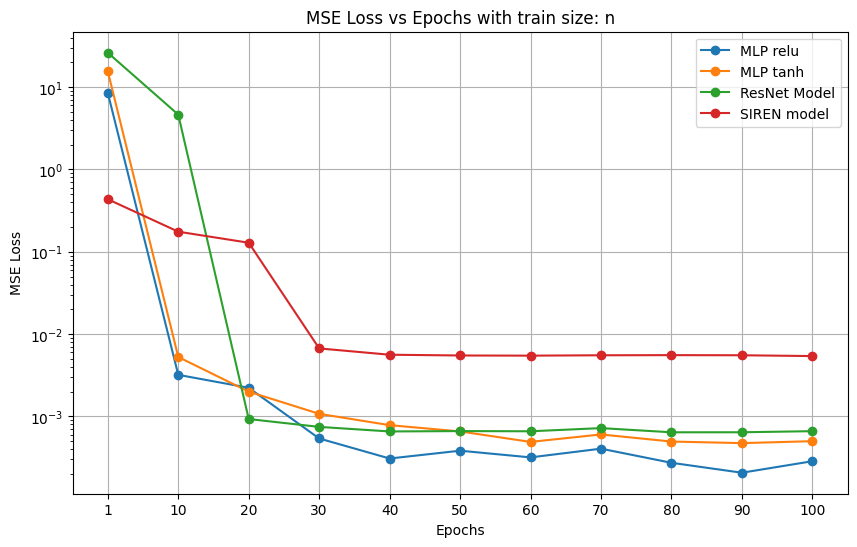

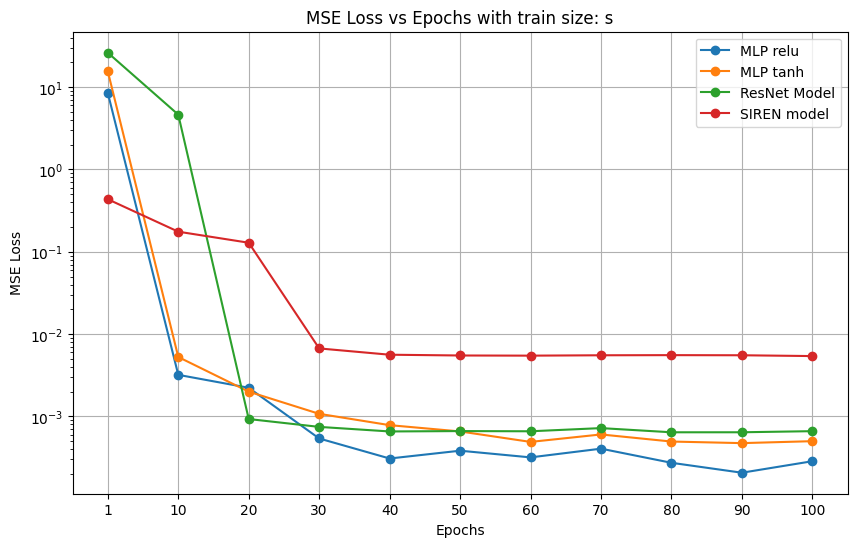

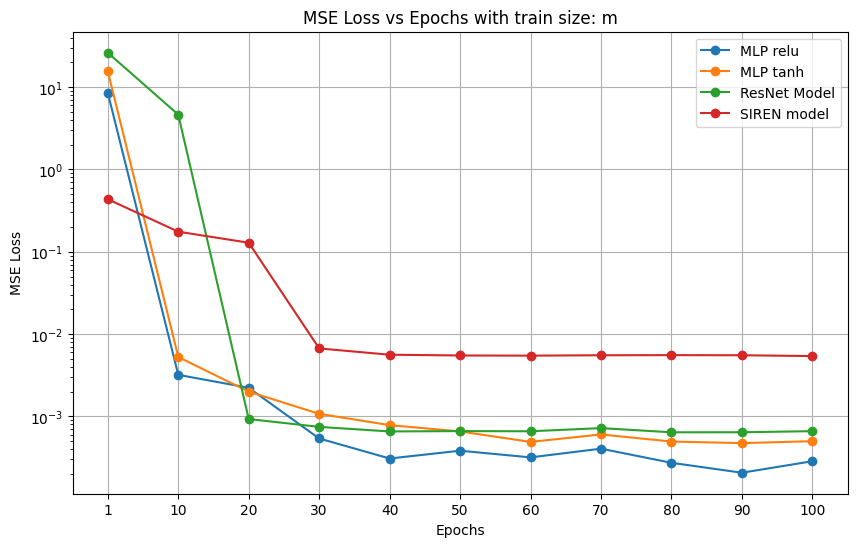

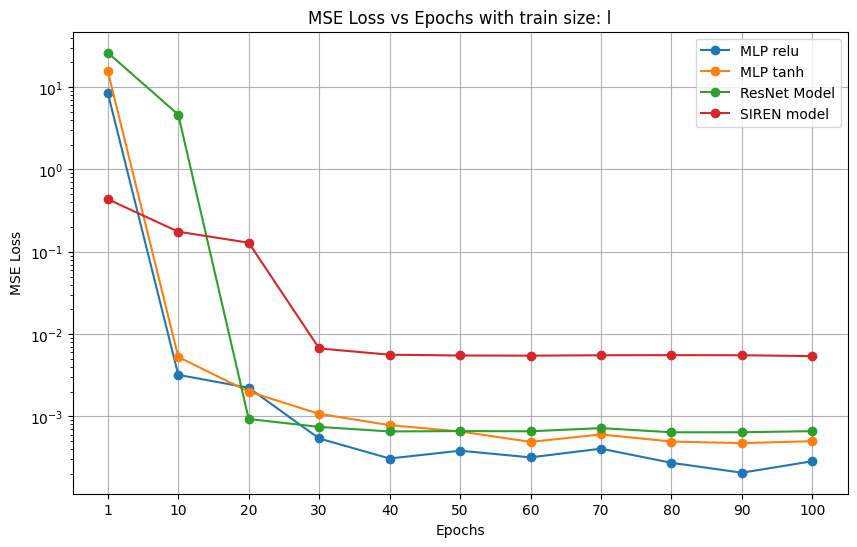

In [16]:
plt.figure(figsize=(10, 6))

for size in train_data[list(train_data.keys())[0]].keys():
	plt.figure(figsize=(10, 6))
	
	# Loop through each model and plot
	for model_name, model_data in train_data.items():
		if model_name in exclude_models[0]:
			continue

		epochs = list(model_data["n"].keys())
		mse_values = [model_data["n"][epoch]["mse"] for epoch in epochs]
		
		plt.plot(epochs, mse_values, label=model_name, marker='o')

	plt.xlabel("Epochs")
	plt.ylabel("MSE Loss")
	plt.title(f"MSE Loss vs Epochs with train size: {size}")
	plt.yscale('log')
	plt.legend()
	plt.grid(True)

	folder_path = "graphs/training"
	os.makedirs(folder_path, exist_ok=True)
	plt.savefig(f"{folder_path}/{size}")
	plt.show()

## MSE

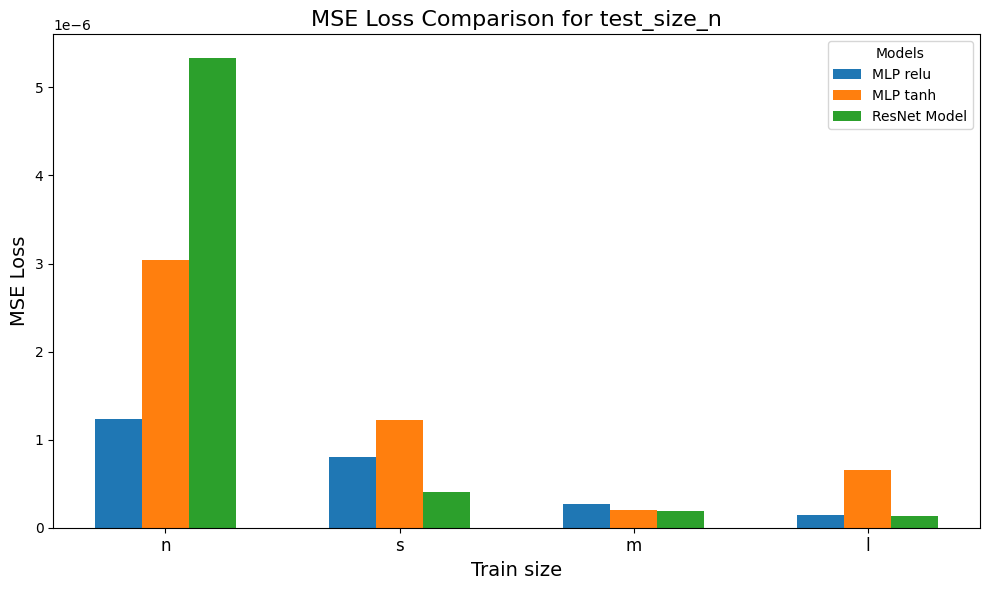

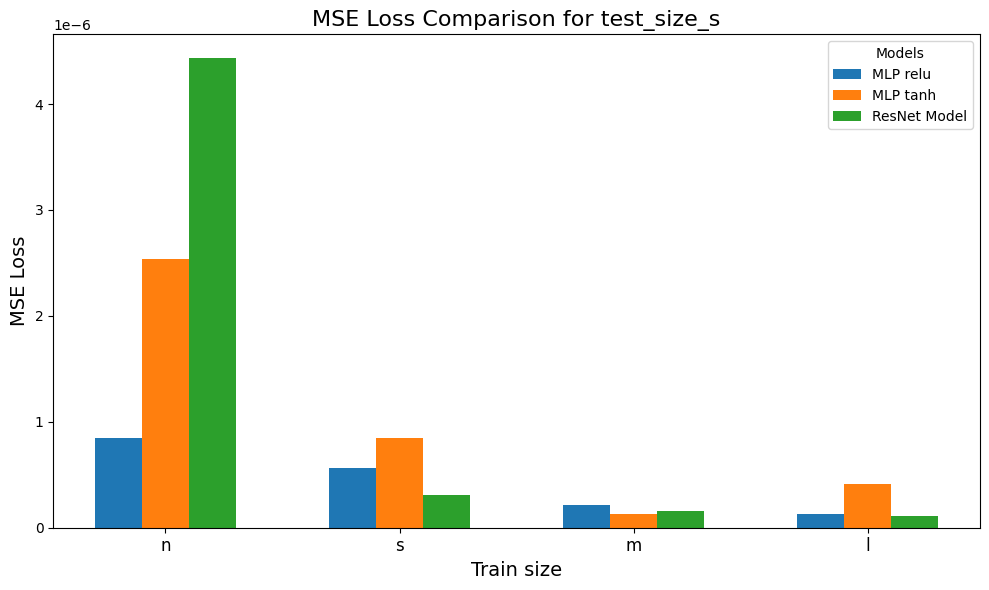

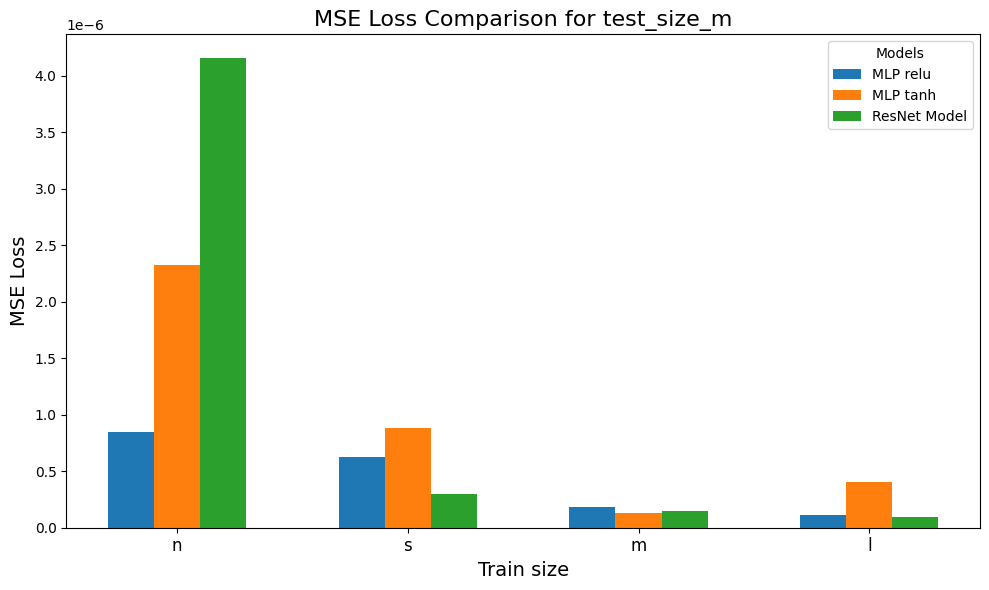

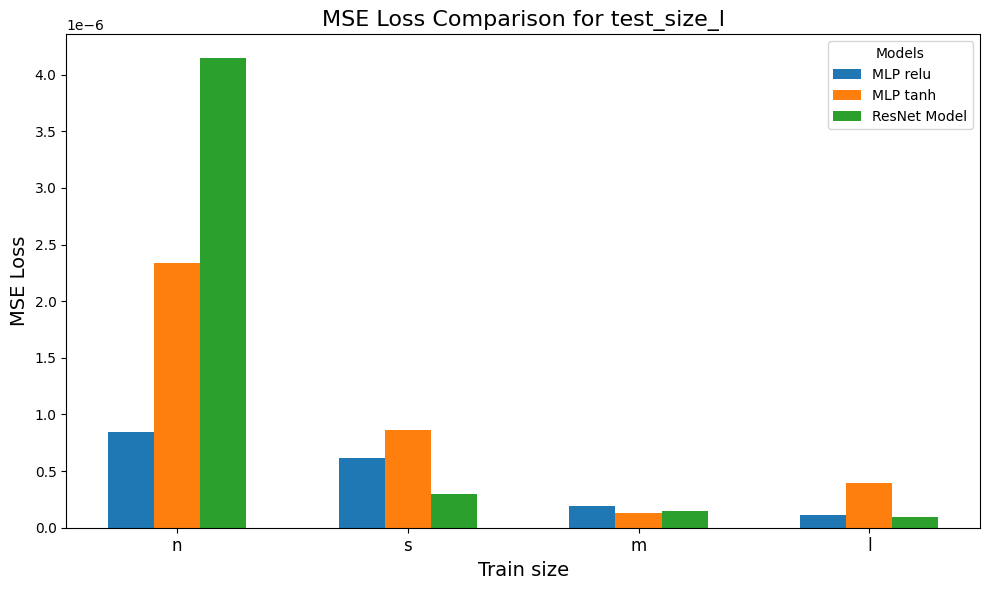

In [11]:
for size in test_data.keys():
	test_size = test_data[size]
	models = [model for model in test_size.keys() if model not in exclude_models]
	modes = list(next(iter(test_size.values())).keys()) 
	mse_loss = {model: [test_size[model][mode]['mse'] for mode in modes] for model in models}

	x = np.arange(len(modes)) 
	width = 0.2 
	fig, ax = plt.subplots(figsize=(10, 6))

	for i, model in enumerate(models):
		ax.bar(x + i * width, mse_loss[model], width, label=model)

	ax.set_xticks(x + width * (len(models) - 1) / 2)
	ax.set_xticklabels(modes, fontsize=12)
	ax.set_xlabel('Train size', fontsize=14)
	ax.set_ylabel('MSE Loss', fontsize=14)
	ax.set_title(f"MSE Loss Comparison for {size}", fontsize=16)
	ax.legend(title='Models')

	plt.tight_layout()
	folder_path = "graphs/mse"
	os.makedirs(folder_path, exist_ok=True)
	plt.savefig(f"{folder_path}/{size}")
	plt.show()


## MAE

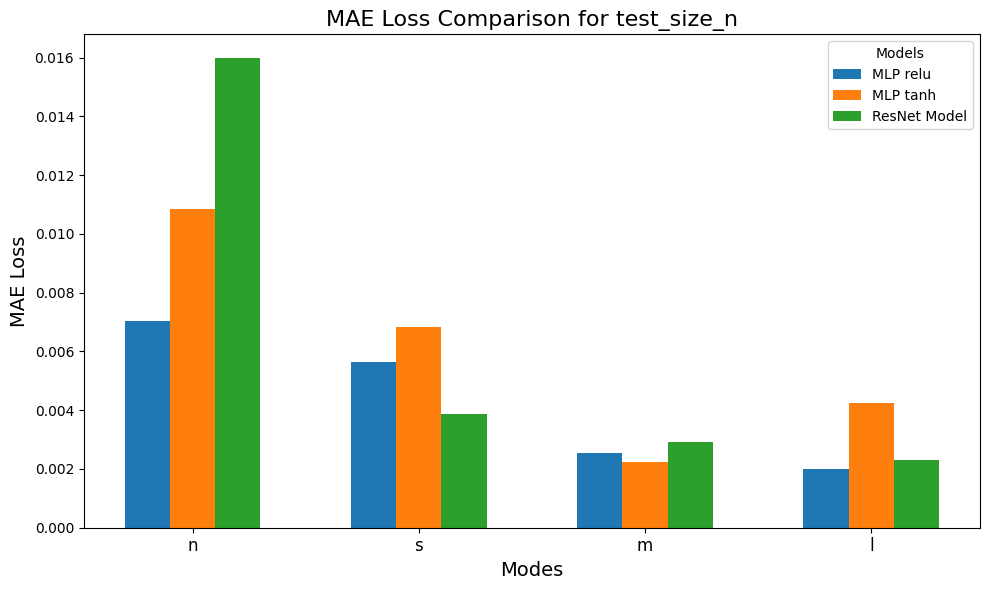

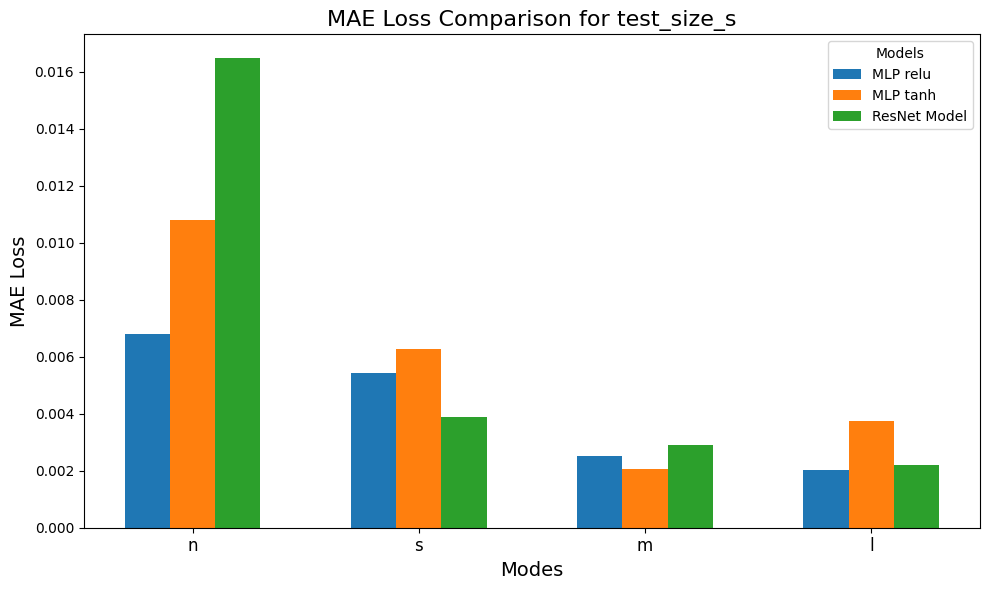

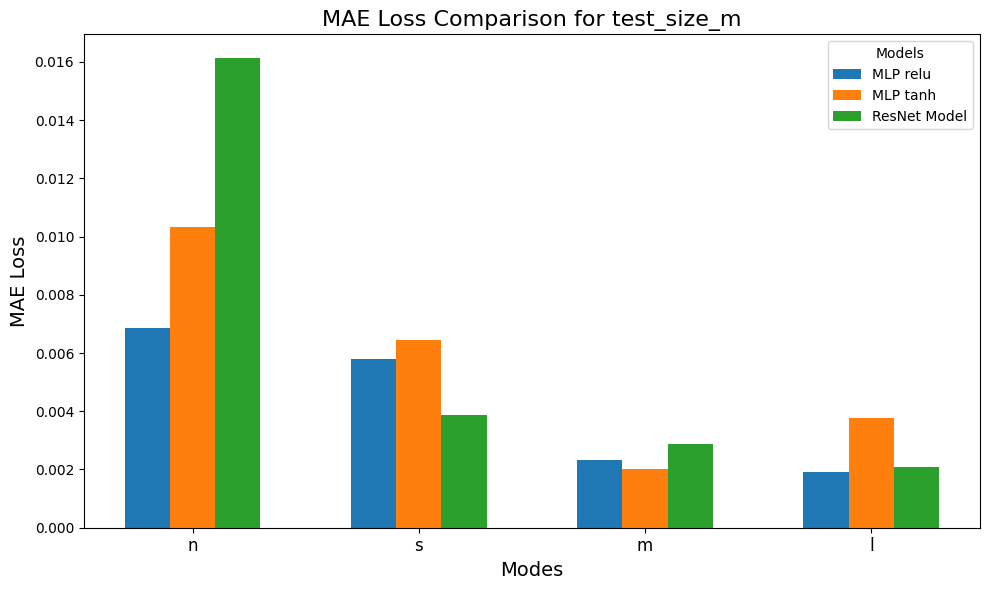

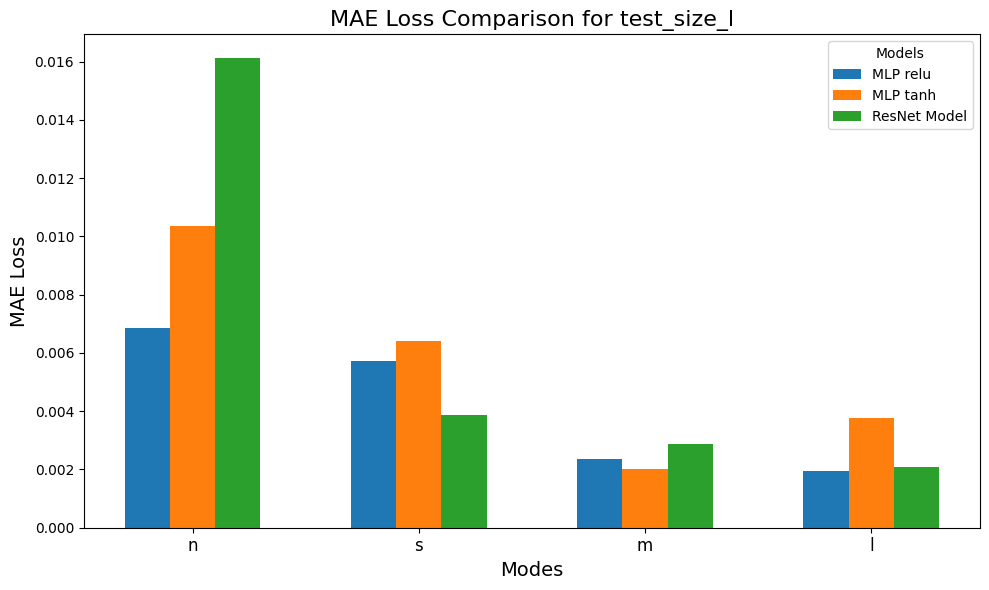

In [12]:
for size in test_data.keys():
	test_size = test_data[size]
	models = [model for model in test_size.keys() if model not in exclude_models]
	modes = list(next(iter(test_size.values())).keys()) 
	mae_loss = {model: [test_size[model][mode]['mae'] for mode in modes] for model in models}

	x = np.arange(len(modes)) 
	width = 0.2 
	fig, ax = plt.subplots(figsize=(10, 6))

	for i, model in enumerate(models):
		ax.bar(x + i * width, mae_loss[model], width, label=model)

	ax.set_xticks(x + width * (len(models) - 1) / 2)
	ax.set_xticklabels(modes, fontsize=12)
	ax.set_xlabel('Modes', fontsize=14)
	ax.set_ylabel('MAE Loss', fontsize=14)
	ax.set_title(f"MAE Loss Comparison for {size}", fontsize=16)
	ax.legend(title='Models')

	plt.tight_layout()
	folder_path = "graphs/mae"
	os.makedirs(folder_path, exist_ok=True)
	plt.savefig(f"{folder_path}/{size}")
	plt.show()


## MRE

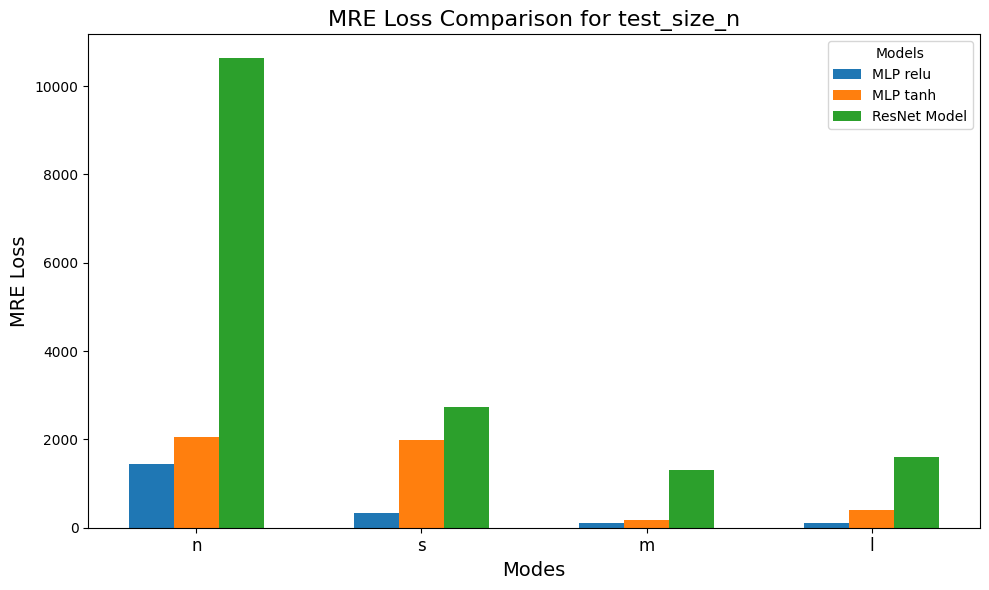

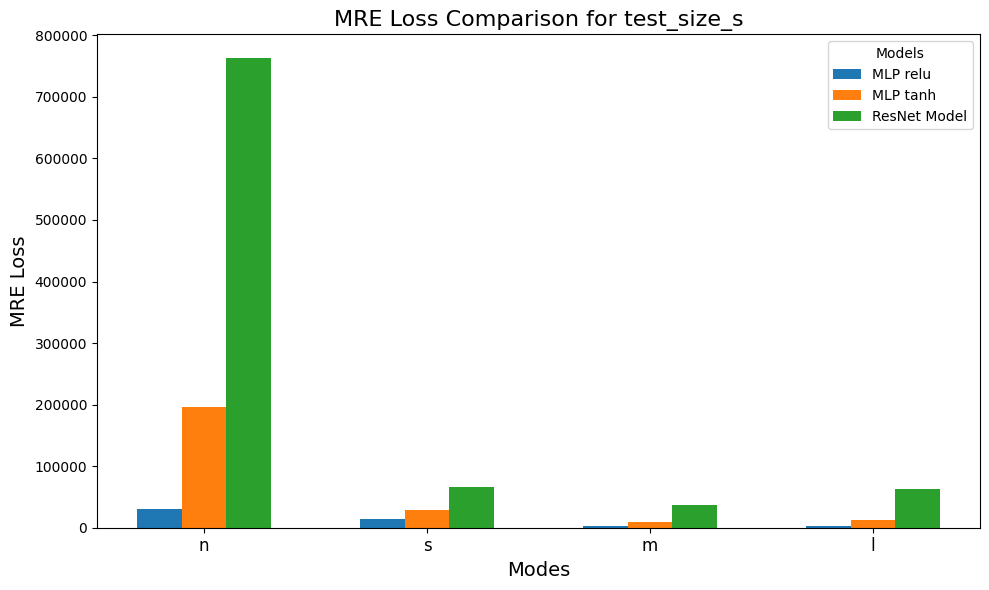

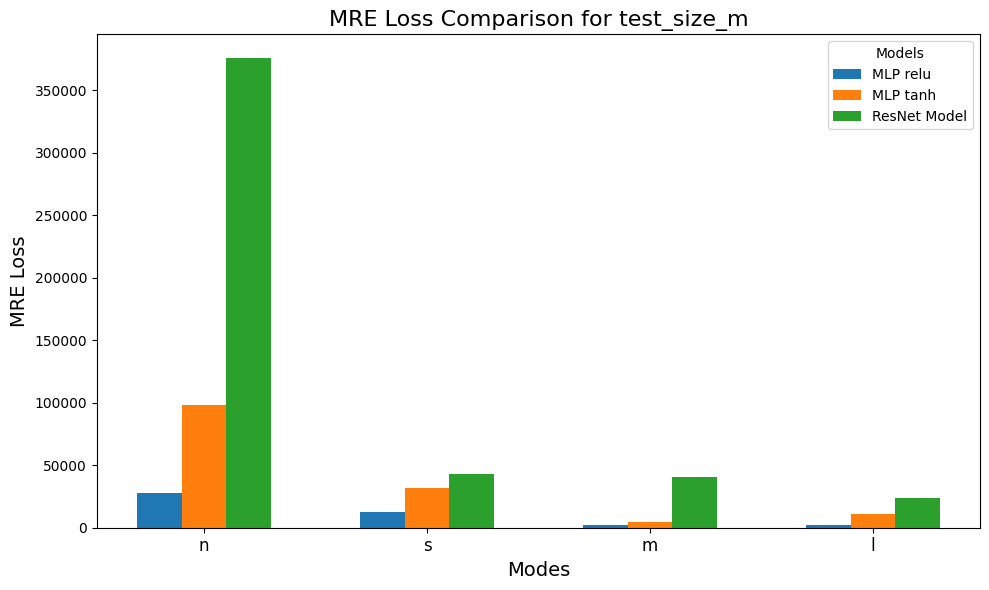

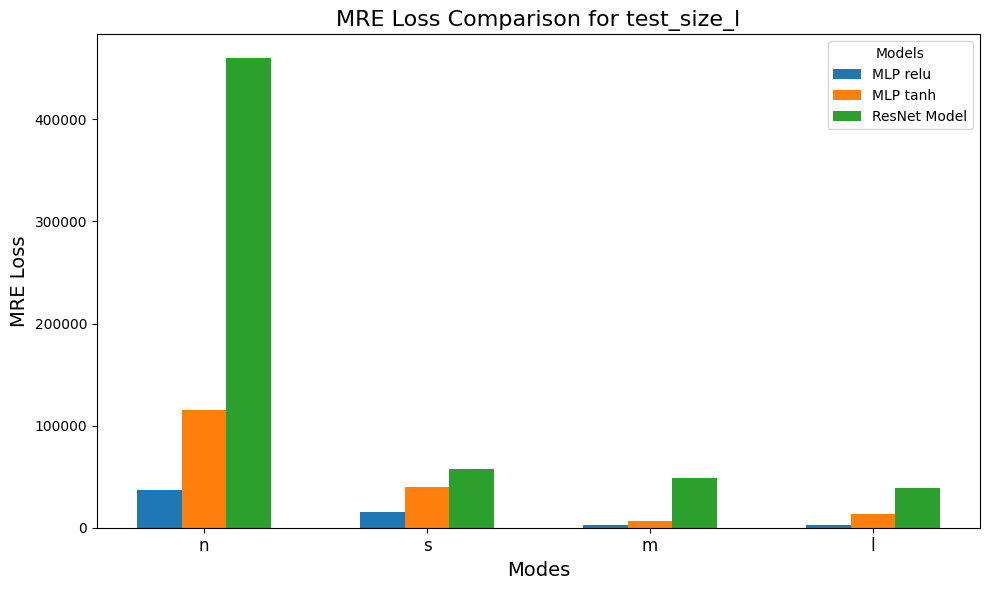

In [13]:
for size in test_data.keys():
	test_size = test_data[size]
	models = [model for model in test_size.keys() if model not in exclude_models]
	modes = list(next(iter(test_size.values())).keys()) 
	mre_loss = {model: [test_size[model][mode]['mre'] for mode in modes] for model in models}

	x = np.arange(len(modes)) 
	width = 0.2 
	fig, ax = plt.subplots(figsize=(10, 6))

	for i, model in enumerate(models):
		ax.bar(x + i * width, mre_loss[model], width, label=model)

	ax.set_xticks(x + width * (len(models) - 1) / 2)
	ax.set_xticklabels(modes, fontsize=12)
	ax.set_xlabel('Modes', fontsize=14)
	ax.set_ylabel('MRE Loss', fontsize=14)
	ax.set_title(f"MRE Loss Comparison for {size}", fontsize=16)
	ax.legend(title='Models')

	plt.tight_layout()
	folder_path = "graphs/mre"
	os.makedirs(folder_path, exist_ok=True)
	plt.savefig(f"{folder_path}/{size}")
	plt.show()


## Implied volatility

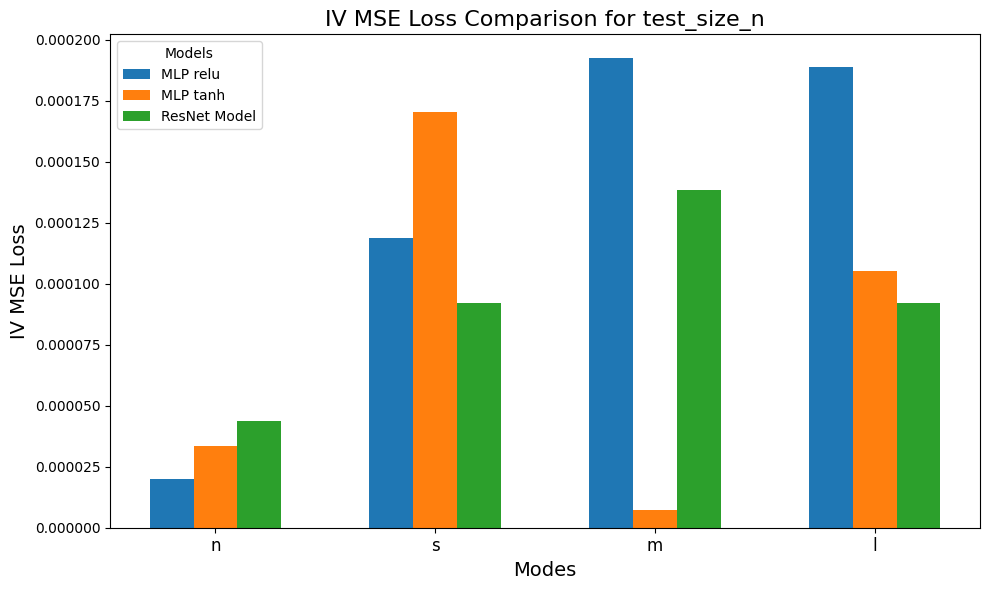

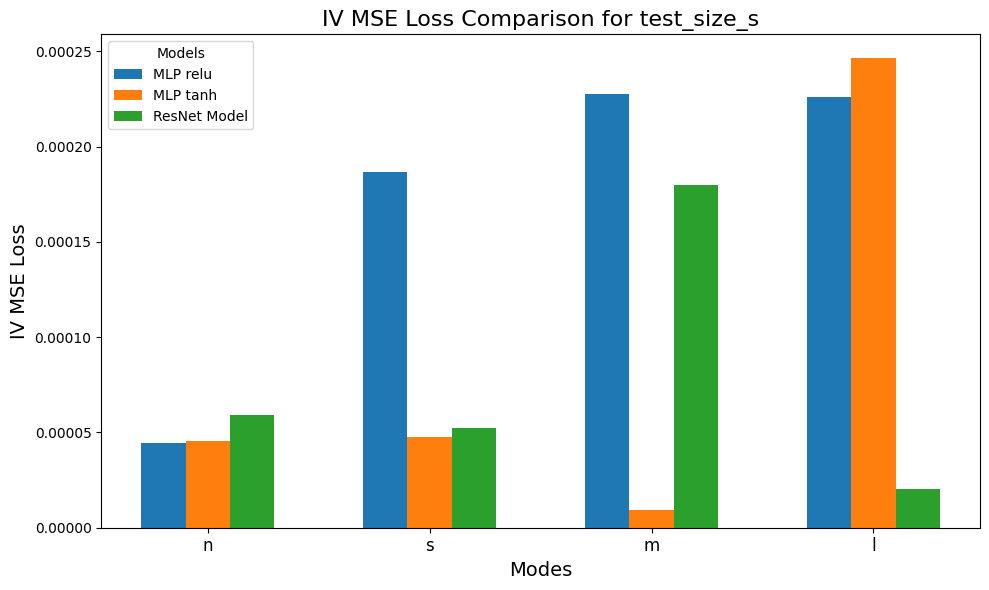

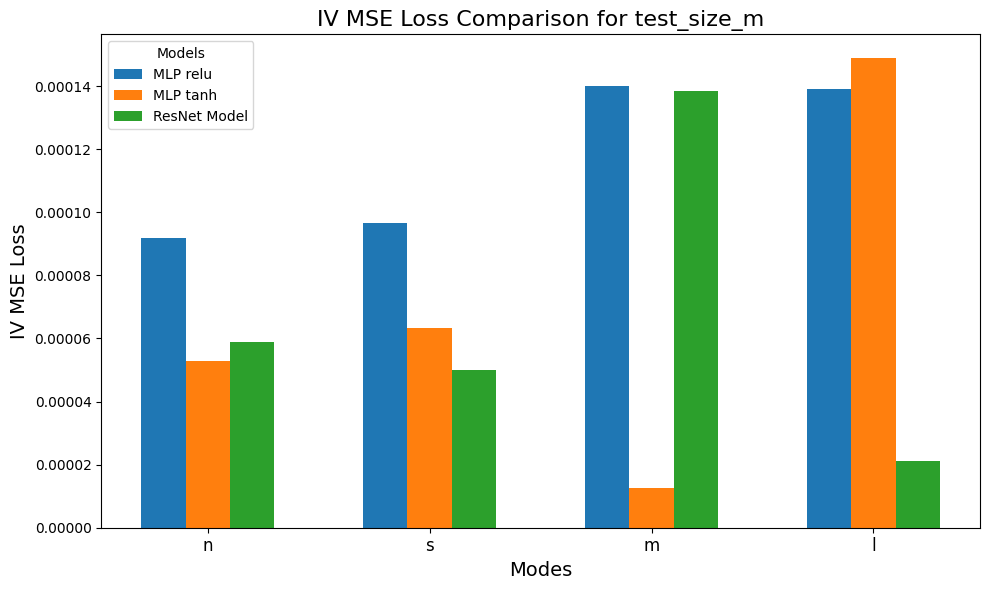

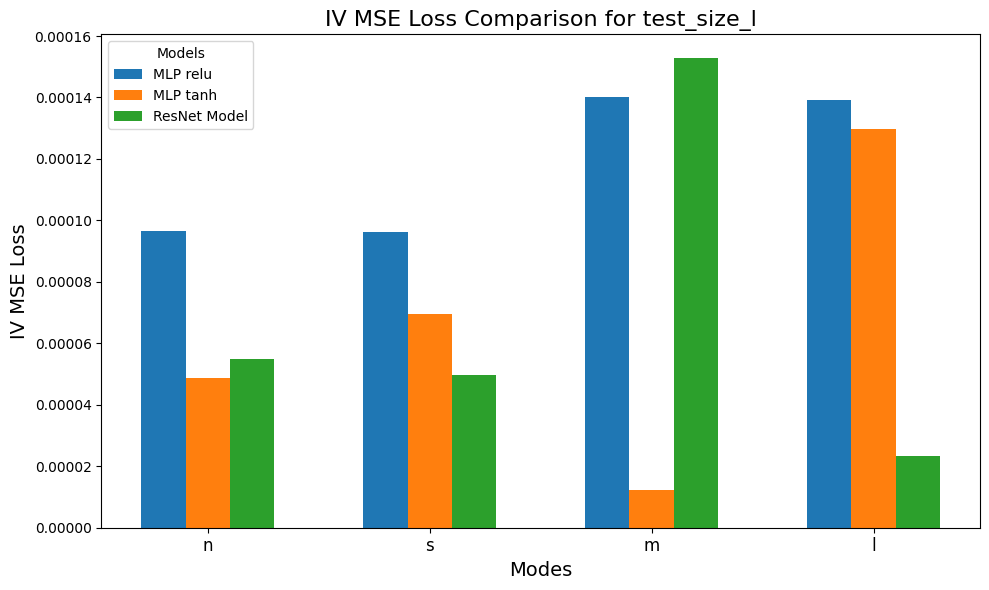

In [14]:
for size in test_data.keys():
	test_size = test_data[size]
	models = [model for model in test_size.keys() if model not in exclude_models]
	modes = list(next(iter(test_size.values())).keys()) 
	iv_mse_loss = {model: [test_size[model][mode]['iv_mse'] for mode in modes] for model in models}

	x = np.arange(len(modes)) 
	width = 0.2 
	fig, ax = plt.subplots(figsize=(10, 6))

	for i, model in enumerate(models):
		ax.bar(x + i * width, iv_mse_loss[model], width, label=model)

	ax.set_xticks(x + width * (len(models) - 1) / 2)
	ax.set_xticklabels(modes, fontsize=12)
	ax.set_xlabel('Modes', fontsize=14)
	ax.set_ylabel('IV MSE Loss', fontsize=14)
	ax.set_title(f"IV MSE Loss Comparison for {size}", fontsize=16)
	ax.legend(title='Models')

	plt.tight_layout()
	folder_path = "graphs/iv_mse"
	os.makedirs(folder_path, exist_ok=True)
	plt.savefig(f"{folder_path}/{size}")
	plt.show()


## Greeks

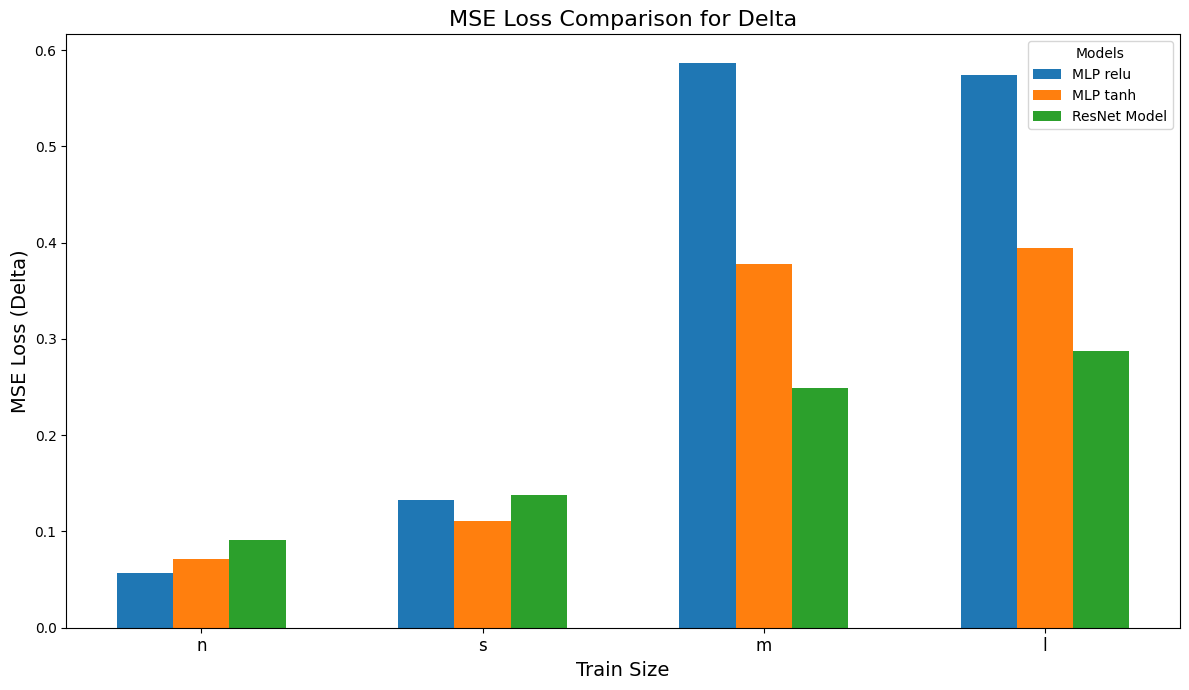

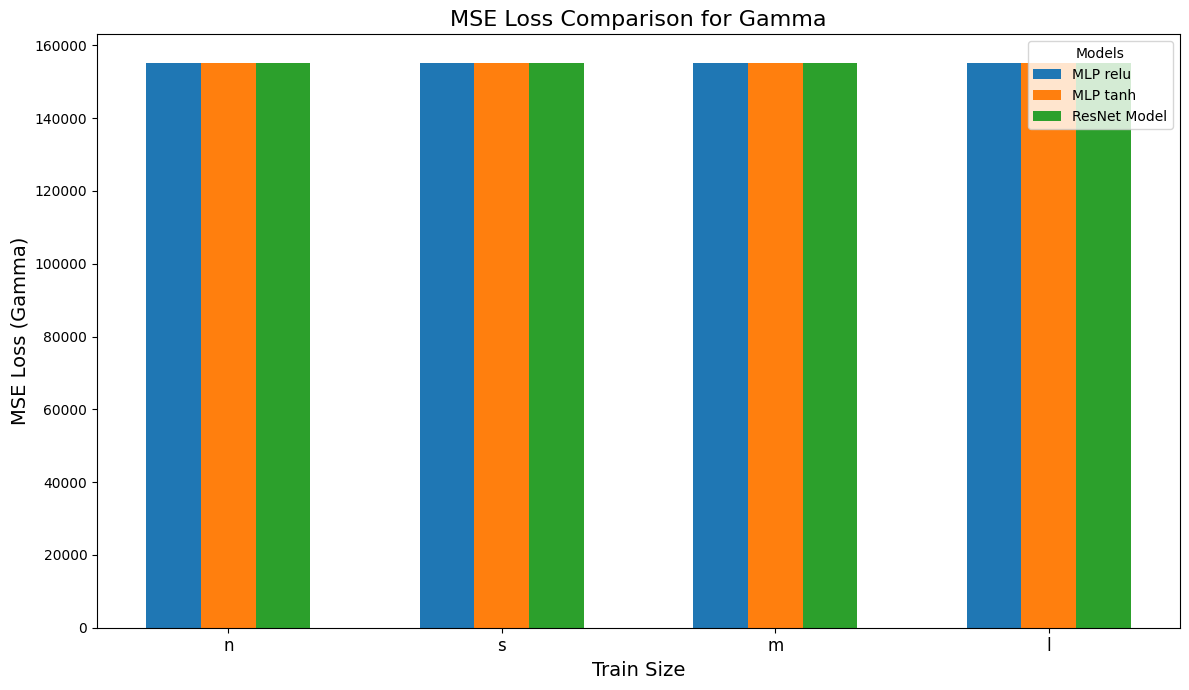

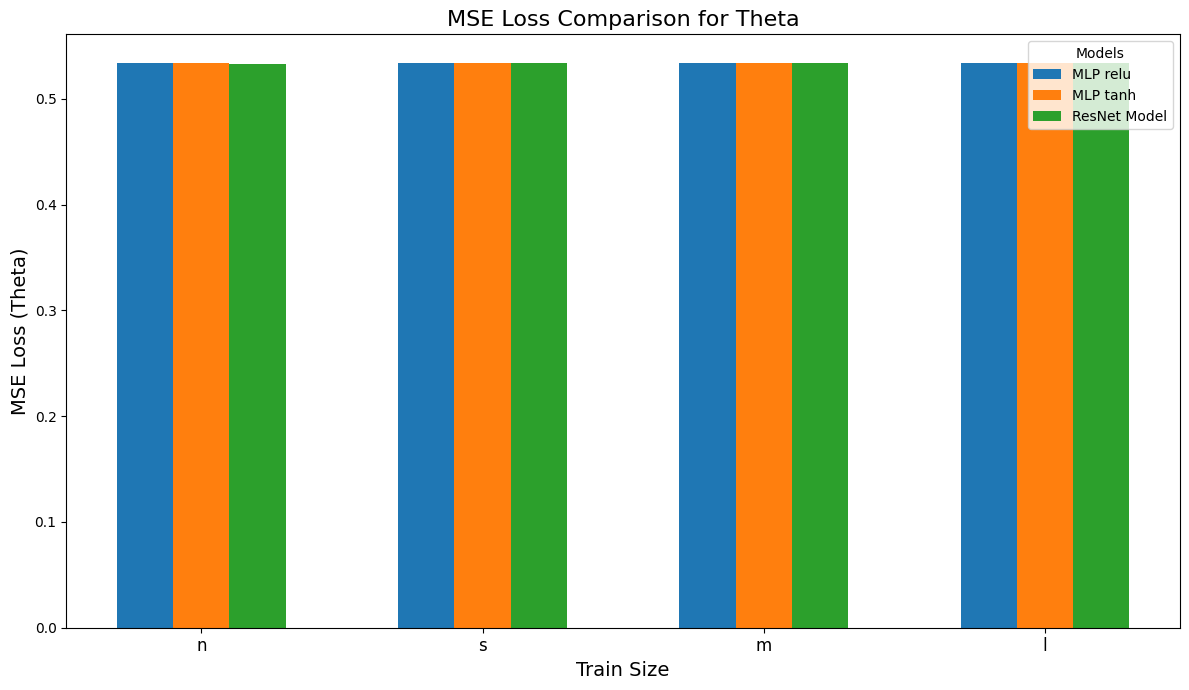

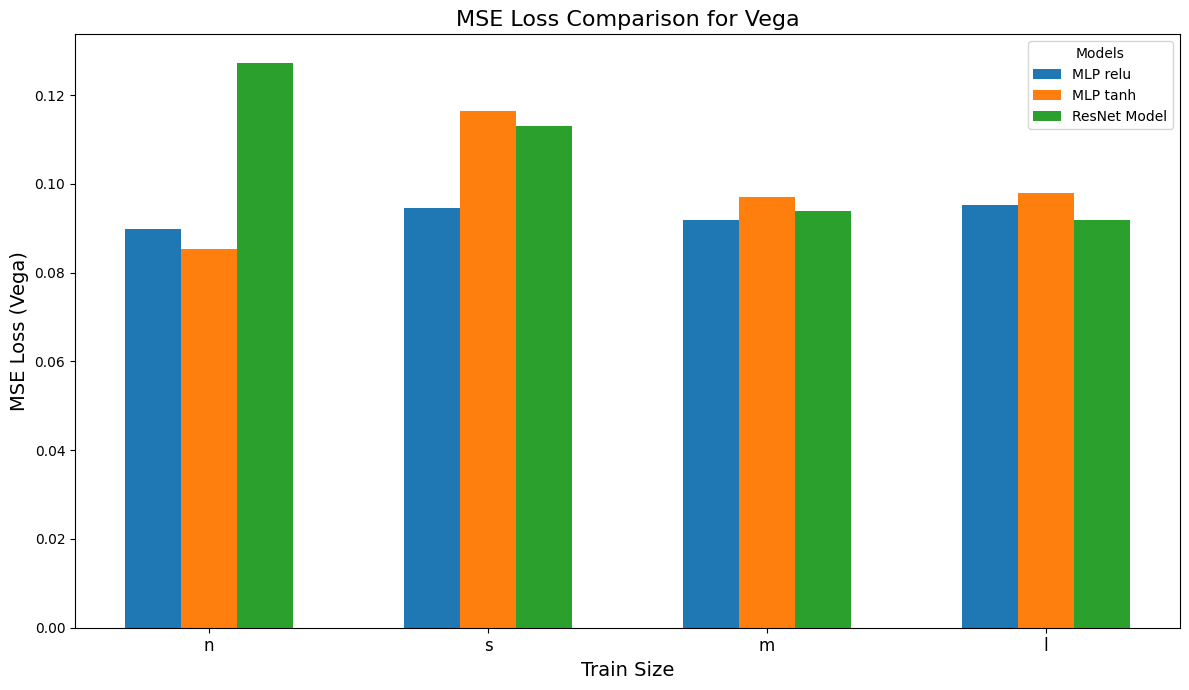

In [15]:
greeks = ['Delta', 'Gamma', 'Theta', 'Vega']

for greek in greeks:
    train_sizes = list(greeks_data.keys())
    models = [model for model in greeks_data[train_sizes[0]].keys() if model not in exclude_models]

    x = np.arange(len(train_sizes)) 
    width = 0.2
    fig, ax = plt.subplots(figsize=(12, 7))

    for i, model in enumerate(models):
        greek_values = [greeks_data[size][model][greek] for size in train_sizes]

        ax.bar(x + i * width, greek_values, width, label=model)

    # Configure x-axis labels
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(train_sizes, fontsize=12)
    ax.set_xlabel('Train Size', fontsize=14)
    ax.set_ylabel(f'MSE Loss ({greek})', fontsize=14)
    ax.set_title(f'MSE Loss Comparison for {greek}', fontsize=16)
    ax.legend(title='Models')

    plt.tight_layout()
    folder_path = "graphs/greeks"
    os.makedirs(folder_path, exist_ok=True)
    plt.savefig(f"{folder_path}/{greek}_comparison.png")
    plt.show()

## Heatmaps

### K vs T

# **OPTUNA (optional)**

## Generate test data

In [ ]:
num_test_samples = 2000
batch_size = 256

In [56]:
# generate_static_test_data(num_test_samples)

In [ ]:
X_test_tensor, y_test_tensor = load_static_test_data()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Finding optimal hyperparameters

### Define the device

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

### Run the search

In [ ]:
import optuna
import torch
import torch.nn.functional as F

def objective(trial):
	# Define hyperparameters to be optimized
	input_size = 4
	hidden_size = 128
	dropout_p = trial.suggest_float('dropout_p', 0.1, 0.5)
	lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

	model = BlackScholesNet(input_size=input_size, hidden_size=hidden_size, output_size=1)
	model.dropout.p = dropout_p

	optimizer = torch.optim.NAdam(model.parameters(), lr=lr)

	scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

	num_epochs = 100
	for epoch in range(num_epochs):
		model.train()
		epoch_mse = 0
		epoch_mae = 0
		epoch_mre = 0

		for X_batch, y_batch in train_loader:
			X_batch, y_batch = X_batch.to(device), y_batch.to(device)

			optimizer.zero_grad()

			outputs = model(X_batch)
			# outputs = (outputs[:, 0] + outputs[:, 1]) / 2
			y = y_batch

			# mse_loss = F.mse_loss(outputs, y)
			mae_loss = F.l1_loss(outputs, y)
			# relative_errors = torch.abs(outputs - y) / (y + 1e-8)
			# mre_loss = relative_errors.mean()

			mae_loss.backward()
			optimizer.step()

			# epoch_mse += mse_loss.item()
			epoch_mae += mae_loss.item()
			# epoch_mre += mre_loss.item()

		avg_epoch_mae = epoch_mae / len(train_loader)
		scheduler.step(avg_epoch_mae)

	test_msees = 0.
	test_maes = 0.
	test_max_aes = 0.
	test_mres = 0.
	test_max_res = 0.

	model.eval()

	with torch.inference_mode():
		for X_batch, y_batch in test_loader:
			X_batch, y_batch = X_batch.to(device), y_batch.to(device)

			# Forward pass
			outputs = model(X_batch)
			# outputs = (outputs[:, 0] + outputs[:, 1]) / 2

			y = y_batch

			# Mean Absolute Error (MAE)
			abs_errors = torch.abs(outputs - y)
			test_maes += abs_errors.sum().item()

	# avg_test_mse = test_msees / len(test_loader.dataset)
	avg_test_mae = test_maes / len(test_loader.dataset)
	# avg_test_mre = test_mres / len(test_loader.dataset)

	# Return the average MAE as the objective to be minimized
	return avg_test_mae

c:\Users\serpo\Documents\Python\Black\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [273]:
# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Print best parameters and best value
print("Best hyperparameters:", study.best_params)
print("Best MAE:", study.best_value)

[I 2024-11-13 02:13:30,923] A new study created in memory with name: no-name-4d12a20f-78bb-4a37-b8de-b1d08383787d
[I 2024-11-13 02:13:49,594] Trial 0 finished with value: 0.008538148411389517 and parameters: {'dropout_p': 0.29188936206204374, 'lr': 3.6650461245806255e-05}. Best is trial 0 with value: 0.008538148411389517.
[I 2024-11-13 02:14:08,364] Trial 1 finished with value: 0.01606481424222981 and parameters: {'dropout_p': 0.4927096150720369, 'lr': 2.0102768896209213e-05}. Best is trial 0 with value: 0.008538148411389517.
[I 2024-11-13 02:14:27,561] Trial 2 finished with value: 0.006898602722963613 and parameters: {'dropout_p': 0.2903698277645128, 'lr': 0.0002805596088872334}. Best is trial 2 with value: 0.006898602722963613.
[I 2024-11-13 02:14:46,363] Trial 3 finished with value: 0.001978334345428275 and parameters: {'dropout_p': 0.32277925052099243, 'lr': 0.009128901482677115}. Best is trial 3 with value: 0.001978334345428275.
[I 2024-11-13 02:15:05,228] Trial 4 finished with va

Best hyperparameters: {'dropout_p': 0.10830718268190546, 'lr': 0.09638266753852863}
Best MAE: 0.0005869729237254167


Best hyperparameters: {'dropout_p': 0.10830718268190546, 'lr': 0.09638266753852863}
Best MAE: 0.0005869729237254167

Best hyperparameters: {'dropout_p': 0.20862014926048447, 'lr': 0.0002448376394581503}
Best MAE: 0.00049047276004533371